# Задача оценки качества изображений

В силу естественных причин, изображения, получаемые с фото/видео устройств, подвержены искажениям. Это может быть связано с условиями освещения, с движением во время съемки, несовершенствам параметров камеры и т.п. Все это влияет на качество получаемого изображения.

Оценка качества изображений (Image quality assessment, IQA) играет важную роль в различных приложениях обработки изображений. Она может использоваться, например, для таких целей как:
- выбор кадра наилучшего качества среди множества схожих кадров
- помощь в подстроении параметров камеры для получения изображений/видео более хорошего качества
- чистка датасета: имея датасет изображений, оценить качество всех входящих в него картинок и удалить из него самые плохие по качеству
- улучшение качества изображения (может использоваться в качестве метрики оценки качества работы алгоритма улучшения изображений, т.н. image enhancement) и т.п.

Первый приходящий в голову способ решить все вышеперечисленные задачи $-$ это задействовать живого человека, чтобы он мог взглянуть своими глазами и оценить качество картинки вручную. Потому что в большинстве случаев человеческий глаз и является "конечным пользователем" алгоритмов, связанных с качеством изображений. Это довольно субъективно, поэтому обычно используется усредненная оценка, составленная из мнений разных людей. Т.н. MOS (Mean Opinion Score). К сожалению, этот метод является довольно медленным, трудозатратным и дорогим. Поэтому и возникает острая потребность к автоматическом алгоритму IQA.

В большинстве задач используется не абсолютное понятие качества, а относительное (т.е. картинки сравниваются друг с другом). Существуют метрики оценки качества, задействующие референсное изображение (эталон). Одним из таких методов является PSNR (Peak Signal to Noise Ratio, https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio). Минусом таких метрик является то, что в реальной жизни референсы обычно не доступны. Преимуществом $-$ то, что они объективны.

## Данные

### О датасете и таргете

Датасет состоит из 16.5K искаженных изображений, соответствующих 3K референсным изображениям. Все изображения хранятся в формате png. Датасет уже поделен на train и test. Файлы именуются так: RR_D.png, где RR - номер соответствующего референса (сами референсы в датасет не включены), D - тип искажения. Всего используется 5 типов искажений, таких как размытие по Гауссу, сжатие, линейное преобразование, аддитивный гауссовский шум (поканально и в компоненте яркости).

Файл train.csv содержит PSNR для всех искаженных картинок. Чем ниже эта метрика, тем хуже картинка относительно рефересна.

В задании требуется предсказать PSNR (не имея референса).

Примеры картинок из датасета ниже:

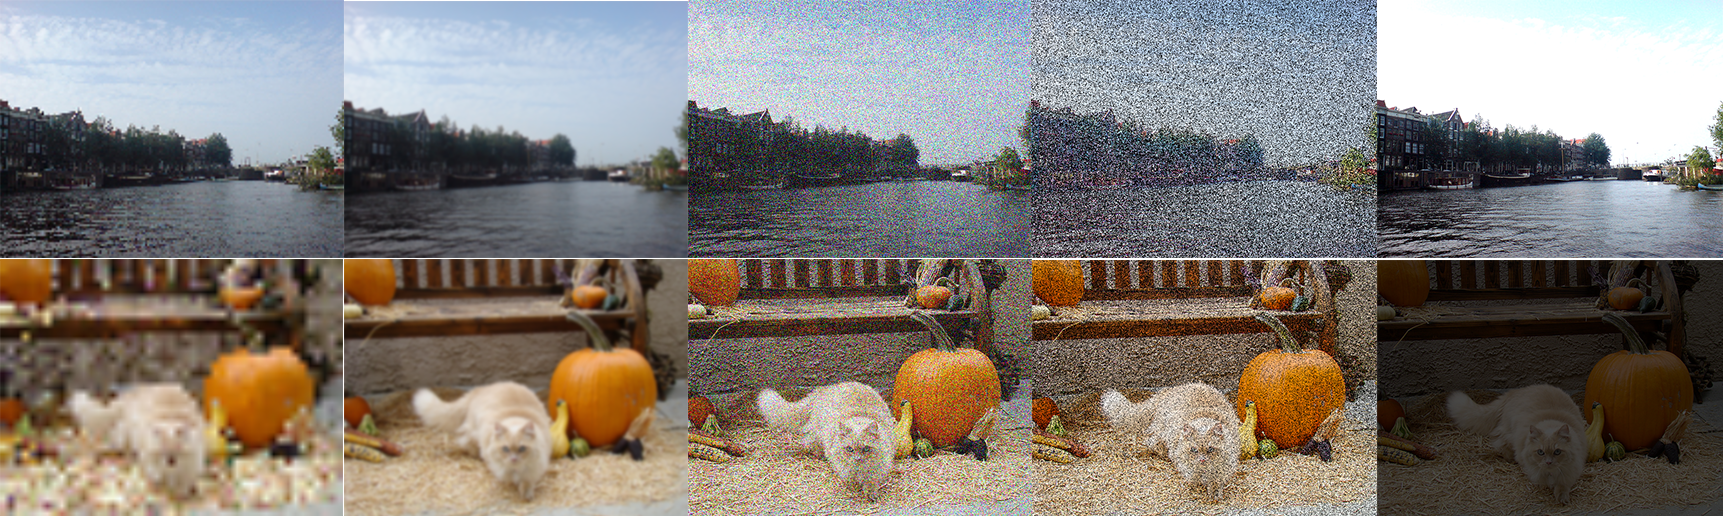

### Загрузка исходных данных

In [6]:
import os
from glob import glob
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

In [7]:
src_path = "files//SBC22_IQA_dataset"  # Здесь укажите путь до вашей папки (локальной, если вы работаете локально или на гугл диске, если в colab (см гайд))

path_2_train_csv = os.path.join(src_path, 'train.csv')
train_df = pd.read_csv(path_2_train_csv)

In [8]:
train_df.head()

img_name       PSNR
0  100083_1.png  29.543164
1  100083_2.png  27.894582
2  100083_3.png  29.350353
3  100083_4.png  27.775248
4  100083_5.png  34.358442

In [9]:
imgs = []
for img_name in tqdm(train_df.img_name.values, total=len(train_df)):
    img = cv2.imread(os.path.join(src_path, 'train', img_name))
    imgs.append(img)

  0%|          | 0/13210 [00:00<?, ?it/s]

In [10]:
path_2_test_csv = os.path.join(src_path, 'sample_submission.csv') # В sample_submission хранятся имена файлов тестовой выборки
test_df = pd.read_csv(path_2_test_csv)

In [11]:
# Загрузка тестовой выборки
# Можно запустить ее сразу, а можно в конце (чтобы сейчас время не тратить)
test_imgs = []
for img_name in tqdm(test_df.img_name.values, total=len(test_df)):
    img = cv2.imread(os.path.join(src_path, 'test', img_name))
    test_imgs.append(img)

  0%|          | 0/3310 [00:00<?, ?it/s]

In [12]:
imgs = np.array(imgs)

C:\Users\Admin\AppData\Local\Temp\ipykernel_26448\1041896984.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgs = np.array(imgs)


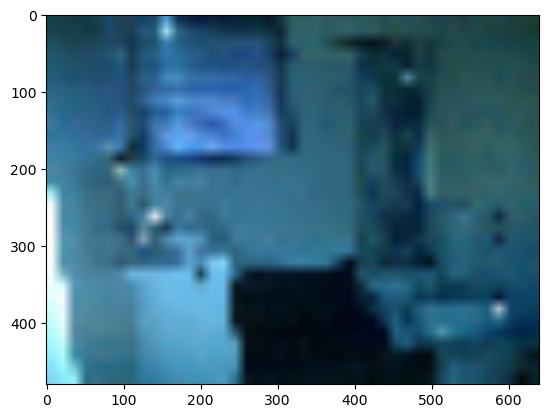

In [14]:
# Посмотрим пример картинки из датасета, который мы загрузили
ind = np.random.randint(0, len(imgs))
plt.imshow(cv2.cvtColor(imgs[ind], cv2.COLOR_BGR2RGB))
plt.show()

Теперь, так как таргет тестового датасета доступен только проверяющим, нам надо разбить обучающую выборку на train и val. И по валидационной выборке выбирать лучшую модель (либо использовать кросс валидацию). В нашем примере будет обычная валидация. Причем разбиение лучше делать с учетом референсных картинок, чтобы избежать зависимости между обучающей и валидационной выборками.

In [15]:
# Получение названий референсных картинок
ref_names = set()
for img_name in train_df.img_name.values:
    ref_names.add(img_name.split('_')[0])
ref_names = sorted(list(ref_names))
random.seed(7)
random.shuffle(ref_names)

In [16]:
# Деление на train и val
train_size = 0.8

train_names = []
train_ids = []
val_names = []
val_ids = []

for i, img_name in enumerate(train_df.img_name.values):

    ref = img_name.split('_')[0]

    if ref in ref_names[:int(train_size * len(ref_names))]:
        train_names.append(img_name)
        train_ids.append(i)
    else:
        val_names.append(img_name)
        val_ids.append(i)
        
print(f"Train size: {len(train_names)}")
print(f"Validation size: {len(val_names)}")

Train size: 10565
Validation size: 2645


In [17]:
tr_df = train_df.set_index('img_name').loc[train_names]
val_df = train_df.set_index('img_name').loc[val_names]


### Получение признаков

Бывают случаи, когда нужно работать не над самой моделью, а над признаками (фичами), которые в нее подаются. И если признаки достаточно хорошие и подходящие под задачу, то модель может быть совершенно простой и при этом работать. Попробуйте подступить к данной задаче именно с этой точки зрения.

In [20]:
from skimage.feature import greycomatrix, greycoprops

def brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v = hsv[..., 2].mean()
    return v / 255 # normalization

def sharpness_grad_based(img):
    gradx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    grady = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    grad = np.sqrt(gradx * gradx + grady * grady)
    return grad[1: -1, 1: -1].mean()

def contrast(img):
    return img.std().mean()

def texture(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = greycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    return contrast

def get_iqa_fv(img):
    fv = np.empty((0,))
    fv = np.append(fv, brightness(img))
    fv = np.append(fv, sharpness_grad_based(img))
    fv = np.append(fv, contrast(img))
    fv = np.append(fv, texture(img))
    fv = np.append(fv, brightness(img)*texture(img))
    fv = np.append(fv, contrast(img)*sharpness_grad_based(img))

    # ...your features here...
    return fv

def get_features(list_of_imgs):
    features =[]
    for img in tqdm(list_of_imgs):
        features.append(get_iqa_fv(img))
    features = np.vstack(list(features))
    return features

In [21]:
# Определяем максимальные индексы, чтобы избежать выхода за пределы размеров tr_df и val_df
max_train_index = min(len(imgs), len(tr_df)) - 1
max_val_index = min(len(imgs), len(val_df)) - 1

# Фильтруем train_ids и val_ids, чтобы учесть только валидные индексы
filtered_train_ids = [idx for idx in train_ids if idx <= max_train_index and imgs[idx] is not None and imgs[idx].size > 0]
filtered_val_ids = [idx for idx in val_ids if idx <= max_val_index and imgs[idx] is not None and imgs[idx].size > 0]

# Получаем изображения
train_imgs = [imgs[idx] for idx in filtered_train_ids]
val_imgs = [imgs[idx] for idx in filtered_val_ids]

# Извлекаем признаки
X_train = get_features(train_imgs)
X_val = get_features(val_imgs)

# Обновляем целевые массивы
y_train = tr_df.PSNR.values[filtered_train_ids]
y_val = val_df.PSNR.values[filtered_val_ids]

  0%|          | 0/2998 [00:00<?, ?it/s]

c:\Users\Admin\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
c:\Users\Admin\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
c:\Users\Admin\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
c:\Users\Admin\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
c:\Users\Admin\anaconda3\lib\sit

  0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\Admin\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
c:\Users\Admin\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
c:\Users\Admin\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
c:\Users\Admin\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
c:\Users\Admin\anaconda3\lib\sit

### Нормализация данных

Для улучшения качества модели данные можно нормализовать. Таргеты можно привести к диапазону от 0 до 1, признаки можно стандартизовать. Если делать какие то манипуляции с данными, необходимо не забывать  сделать то же самое с тестовой выборкой. При манипуляции с таргетом необходимо в конце сделать обратное преобразование предсказаний (потому что проверяющая система ничего не знает о ваших методах нормализации).

In [22]:
from sklearn.preprocessing import StandardScaler

X_train = StandardScaler().fit_transform(X_train)
X_val = StandardScaler().fit_transform(X_val)

## Обучение и тестирование модели

Как уже было сказано выше, если признаки хорошие, то, возможно, даже самая простая модель справится. Возьмем линейную регрессию.

**ElasticNet**

In [33]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

grid_params = {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]}

grid_model = GridSearchCV(ElasticNet(random_state=43), grid_params, cv=5, scoring='neg_mean_absolute_error')
grid_model.fit(X_train, y_train)

print(f"Best params: {grid_model.best_params_}")

Best params: {'alpha': 0.01, 'l1_ratio': 0.9}


In [23]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


elastic = ElasticNet(alpha = 0.01, l1_ratio = 0.9, random_state=43)
elastic.fit(X_train, y_train)

print(f'MSE = {mean_squared_error(y_val, elastic.predict(X_val))}')
print(f'MAE = {mean_absolute_error(y_val, elastic.predict(X_val))}')
print(f'R^2 = {r2_score(y_val, elastic.predict(X_val))}')

MSE = 2.972961602651709
MAE = 1.5938064150925184
R^2 = -4.657252989481991


**RandomForestRegressor**

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [3, 5, 7, 10], 'min_samples_leaf': [3, 5, 7, 10]}

grid_model = GridSearchCV(RandomForestRegressor(random_state=43), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_model.fit(X_train, y_train)

print(f"Best params: {grid_model.best_params_}")

Best params: {'max_depth': 3, 'min_samples_leaf': 10, 'n_estimators': 200}


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(n_estimators=200, max_depth=3, min_samples_leaf=10, random_state=43)
rf.fit(X_train, y_train)

print(f'MSE = {mean_squared_error(y_val, rf.predict(X_val))}')
print(f'MAE = {mean_absolute_error(y_val, rf.predict(X_val))}')
print(f'R^2 = {r2_score(y_val, rf.predict(X_val))}')

MSE = 1.3987421223074934
MAE = 1.0019448412784353
R^2 = -1.6616684338877707


**XGBoostRegressor**

In [38]:
from xgboost import XGBRegressor

param_grid = {'n_estimators': [50, 100, 200, 350, 400, 450, 500], 'max_depth': [3, 5, 7, 10], 'learning_rate': [0.1, 0.3, 0.7, 1]}

grid_model = GridSearchCV(XGBRegressor(random_state=43), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_model.fit(X_train, y_train)

print(f"Best params: {grid_model.best_params_}")

Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [26]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1)
xgb.fit(X_train, y_train)

print(f'MSE = {mean_squared_error(y_val, xgb.predict(X_val))}')
print(f'MAE = {mean_absolute_error(y_val, xgb.predict(X_val))}')
print(f'R^2 = {r2_score(y_val, xgb.predict(X_val))}')

MSE = 1.1864057401553059
MAE = 1.0631660005415577
R^2 = -1.2576132211884823
